In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score

In [2]:
%matplotlib inline

In [24]:
def liftchart(df: pd.DataFrame, actual: str, predicted: str, buckets: int=10, single_axis: bool=True) -> None:
    # Bucketing the predictions (Deciling is the default)
    xdf = pd.DataFrame(df[[actual, predicted]], columns=[actual, predicted])
    try:
        xdf['predbucket'] = pd.qcut(x=xdf[predicted], q=buckets)
    except:
        xdf['predbucket'] = pd.qcut(x=xdf[predicted] + np.random.uniform(low=0, high=0.001, size=xdf.shape[0]), q=buckets)
    # Getting the performance
    aucperf = roc_auc_score(xdf[actual], xdf[predicted])
    sdf = xdf[[actual, predicted, 'predbucket']].groupby(
        by=['predbucket']).agg({
            actual: [np.mean, sum, len], 
            predicted: np.mean
        }
    )
    sdf.columns = sdf.columns.map(''.join) # I hate pandas multi-indexing
    sdf = sdf.rename({
        actual + 'mean': 'Actual Default Rate', 
        predicted + 'mean': 'Predicted Default Rate'
    }, axis=1)
    if single_axis:
        sdf[['Actual Default Rate', 'Predicted Default Rate']].plot(
            kind='line', style='.-', grid=True, figsize=(12, 8), 
            color=['red', 'blue']
        )
    else:
        sdf[['Actual Default Rate', 'Predicted Default Rate']].plot(
            secondary_y=['Predicted Default Rate'], kind='line', 
            style='.-', grid=True, figsize=(12, 8),
            color=['red', 'blue']
        )
    plt.ylabel('Default Rate')
    plt.xlabel('Decile Value of Predicted Default')
    plt.title('Actual vs Predicted Default Rate sorted by Predicted Decile \nAUC = %.3f' % aucperf)
    plt.xticks(
        np.arange(sdf.shape[0]), 
        sdf['Predicted Default Rate'].round(3)
    )
    plt.show()

In [25]:
n = 10000

In [29]:
# Generating the data
np.random.seed(0)
x_1 = np.random.poisson(lam=5, size=n)
x_2 = np.random.poisson(lam=2, size=n)
x_3 = np.random.poisson(lam=12, size=n)
e = np.random.normal(size=n, loc=0, scale=1.)

In [33]:
# Setting the coefficient values to give us a ~5% default rate
b_1, b_2, b_3 = -0.005, -0.03, -0.15
ylogpred =  x_1 * b_1 + x_2 * b_2 + x_3 * b_3 + e
yprob = 1./ (1.+ np.exp(-ylogpred))
yclass = np.where(yprob >= 0.5, 1, 0)
xs = np.hstack([
  x_1.reshape(n, 1), 
  x_2.reshape(n, 1), 
  x_3.reshape(n, 1)
])
xs = sm.add_constant(xs)

In [38]:
# Using the model from before!
pdf = pd.DataFrame(xs, columns=['intercept', 'x1', 'x2', 'x3'])
pdf['actual'] = yclass
pdf['truth'] = pdf['actual'] + np.random.uniform(low=0, high=0.001, size=pdf.shape[0])

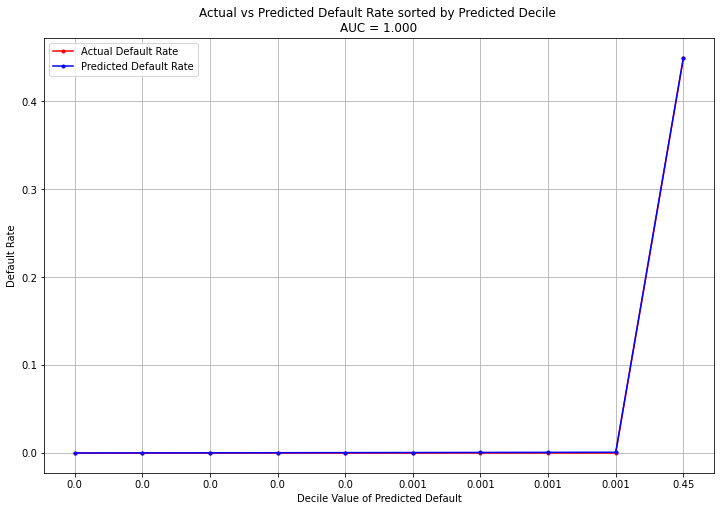

In [42]:
liftchart(pdf, 'actual', 'truth', 10)

In [43]:
pdf.head()

,intercept,x1,x2,x3,actual,truth
0,1.0,9.0,3.0,9.0,0,0.000733
1,1.0,5.0,1.0,14.0,0,0.000056
2,1.0,6.0,0.0,10.0,0,0.000094
3,1.0,5.0,2.0,17.0,0,0.000107
4,1.0,5.0,0.0,14.0,0,0.000783


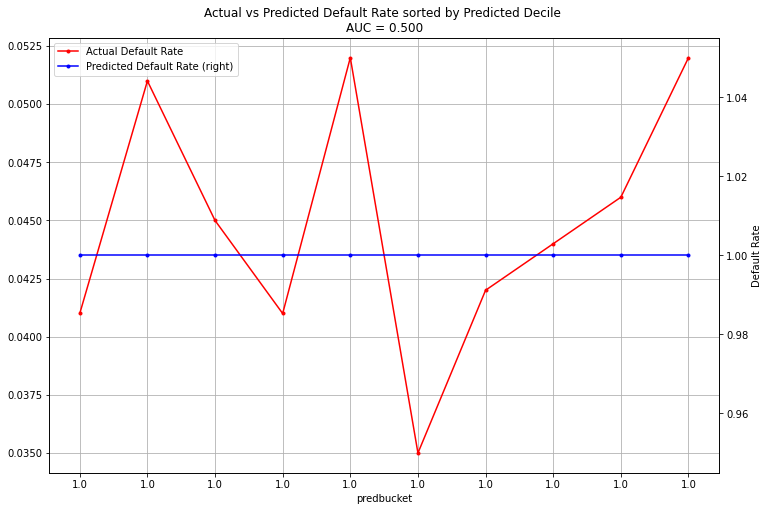

In [44]:
# Intercept
liftchart(pdf, 'actual', 'intercept', 10, False)

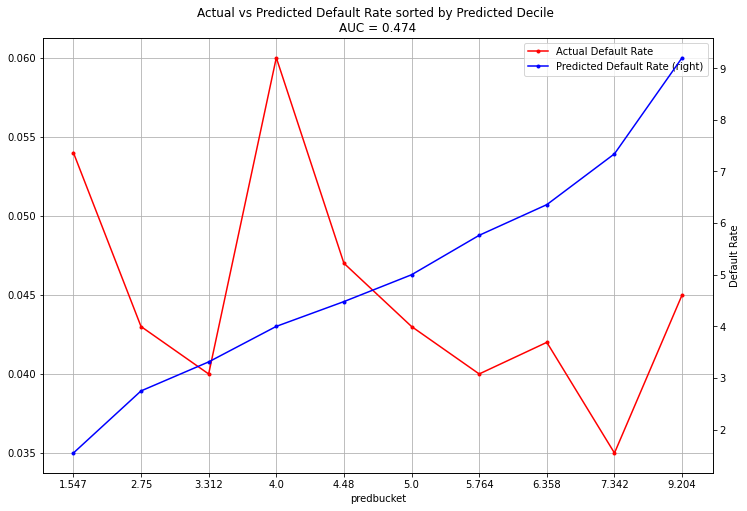

In [45]:
# Feature 1
liftchart(pdf, 'actual', 'x1', 10, False)

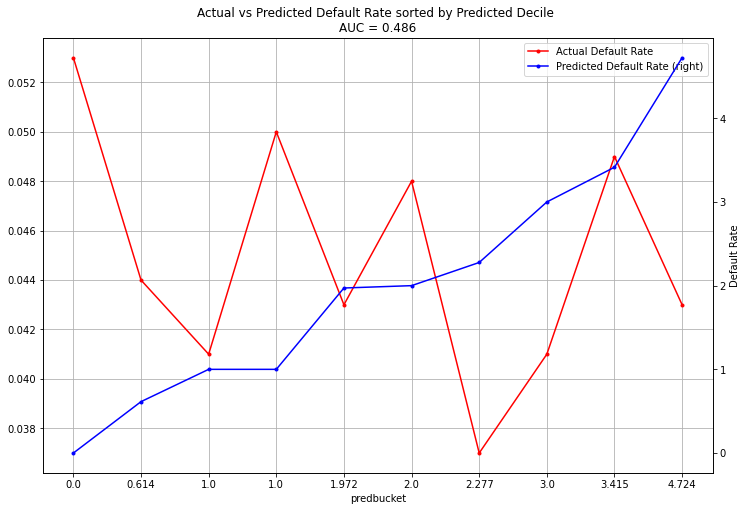

In [46]:
# Feature 2
liftchart(pdf, 'actual', 'x2', 10, False)

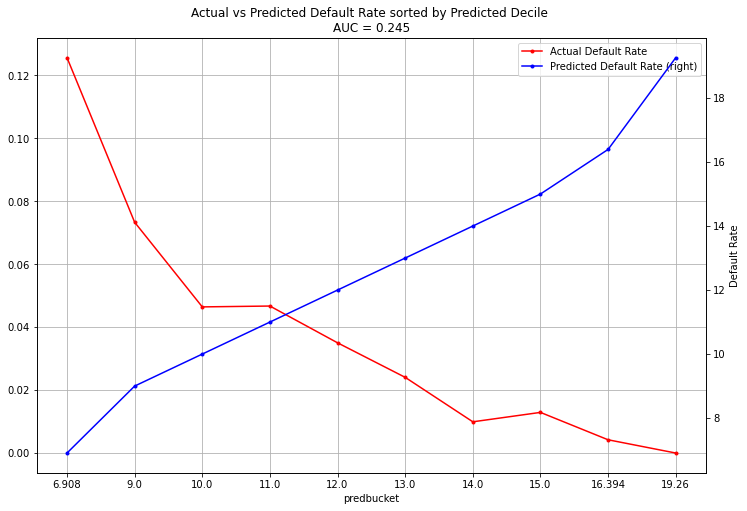

In [47]:
# Feature 3
liftchart(pdf, 'actual', 'x3', 10, False)

In [48]:
# Adding an intercept to the matrix
xs = sm.add_constant(xs)
model = sm.Logit(yclass, xs)
# All that work just to run .fit(), how terribly uninteresting
res = model.fit()
print(res.summary())

pdf['preds'] = res.predict(xs)

Optimization terminated successfully.
         Current function value: 0.163863
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9996
Method:                           MLE   Df Model:                            3
Date:                Fri, 01 Apr 2022   Pseudo R-squ.:                  0.1056
Time:                        17:45:26   Log-Likelihood:                -1638.6
converged:                       True   LL-Null:                       -1832.2
Covariance Type:            nonrobust   LLR p-value:                 1.419e-83
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4535      0.209      2.166      0.030       0.043       0.864
x1            -0.0439      0.